# Covid Death forecasting

## Setup
Inport necesary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
import datetime

keras = tf.keras

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
  
def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
    
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

# Data Loading
In order to build our model, we can begin by importing the dataset. We first need to upload the latest version of the dataset.

In [ ]:
df = pd.read_csv('/content/MuertesUpT2020_2021Nov.csv')

After downloading the dataset, we need to format the data.

In [ ]:
df = df.dropna()
df.head

<bound method NDFrame.head of      CountDEF   FECHA_DEF
0           1  24/01/2020
1           4  07/02/2020
2           3  24/02/2020
3           7  03/03/2020
4           7  13/03/2020
..        ...         ...
562       546  27/09/2021
563       532  28/09/2021
564       404  29/09/2021
565       148  30/09/2021
566         2  01/10/2021

[567 rows x 2 columns]>

In [ ]:
#df['FECHA_DEF'] = pd.to_datetime(df['FECHA_DEF'], format='%Y/%m/%d')
df['FECHA_DEF'] = pd.to_datetime(df['FECHA_DEF'], format='%d/%m/%Y')

In [ ]:
df.dtypes

CountDEF              int64
FECHA_DEF    datetime64[ns]
dtype: object

In [ ]:
df = df.set_index('FECHA_DEF')

In [ ]:
#time = df["FECHA_DEF"].to_numpy()
time = df.index.values

In [ ]:
time.dtype

dtype('<M8[ns]')

In [ ]:
#print(time)

In [ ]:
print(time[535])

2021-08-31T00:00:00.000000000


## Plot graph

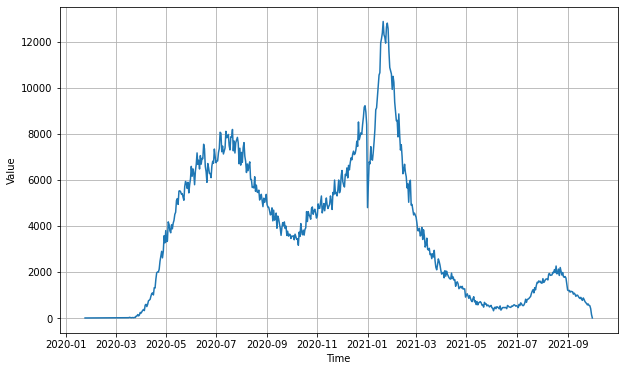

In [ ]:
series = df.to_numpy()
#series = df["CountDEF"].to_numpy()

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [ ]:
split_time = 470
split_time_pred = 535
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
#print(x_train)

## Naive Forecast (testing if the code works, dummy code)

In [ ]:
naive_forecast = series[split_time - 1:-1]

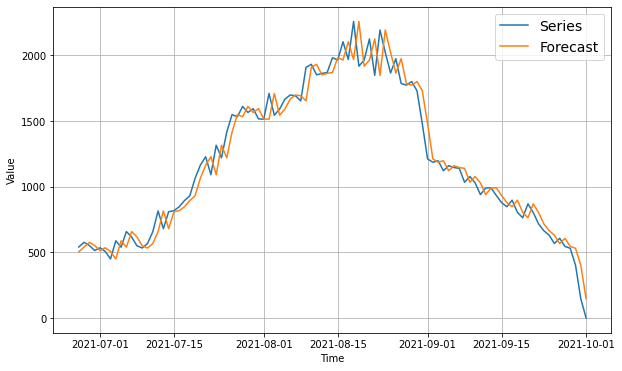

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, naive_forecast, label="Forecast")

## Scale data

In [ ]:
scaler = MinMaxScaler()

#.reshape(-1,1)
x_train = scaler.fit_transform(x_train.reshape(-1,1))
x_valid = scaler.fit_transform(x_valid.reshape(-1,1))

In [ ]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [ ]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [ ]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
#window_size = 10
#train_set = window_dataset(x_train, window_size)
#valid_set = window_dataset(x_valid, window_size)

In [ ]:
#print(window_dataset(x_train, window_size))

<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.int64, tf.int64)>


In [ ]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

Compute the best learning rate

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 4
#train_set = seq2seq_window_dataset(x_train, window_size, batch_size=8)
train_set = TimeseriesGenerator(x_train, x_train, length = window_size, batch_size=1)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
466/466 [==============================] - 33s 8ms/step - loss: 0.0335 - mae: 0.1946 - lr: 1.0000e-04
Epoch 2/100
466/466 [==============================] - 4s 8ms/step - loss: 0.0046 - mae: 0.0728 - lr: 1.0798e-04
Epoch 3/100
466/466 [==============================] - 4s 8ms/step - loss: 0.0011 - mae: 0.0323 - lr: 1.1659e-04
Epoch 4/100
466/466 [==============================] - 4s 8ms/step - loss: 0.0010 - mae: 0.0305 - lr: 1.2589e-04
Epoch 5/100
466/466 [==============================] - 4s 8ms/step - loss: 0.0010 - mae: 0.0302 - lr: 1.3594e-04
Epoch 6/100
466/466 [==============================] - 4s 8ms/step - loss: 9.8006e-04 - mae: 0.0297 - lr: 1.4678e-04
Epoch 7/100
466/466 [==============================] - 4s 9ms/step - loss: 0.0010 - mae: 0.0309 - lr: 1.5849e-04
Epoch 8/100
466/466 [==============================] - 4s 8ms/step - loss: 0.0010 - mae: 0.0309 - lr: 1.7113e-04
Epoch 9/100
466/466 [==============================] - 4s 8ms/step - loss: 0.0010 - mae: 0.

(0.0001, 0.1, 0.0, 0.2)

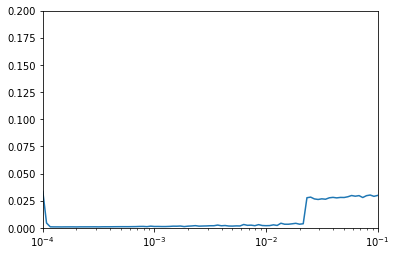

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, .2])

## Built and train dialeted convolution model

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 5
#train_set = seq2seq_window_dataset(x_train, window_size, batch_size=8)
#valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=8)
train_set = TimeseriesGenerator(x_train, x_train, length = window_size, batch_size=1)
valid_set = TimeseriesGenerator(x_valid, x_valid, length = window_size, batch_size=1)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32, 64):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(tf.keras.layers.Dropout(0.2))
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

optimizer = keras.optimizers.Adam(lr=2e-5)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=30)
history = model.fit(train_set, epochs=300,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/300
465/465 [==============================] - 8s 12ms/step - loss: 0.0774 - mae: 0.3249 - val_loss: 0.1405 - val_mae: 0.4755
Epoch 2/300
465/465 [==============================] - 5s 11ms/step - loss: 0.0525 - mae: 0.2617 - val_loss: 0.0860 - val_mae: 0.3540
Epoch 3/300
465/465 [==============================] - 5s 11ms/step - loss: 0.0265 - mae: 0.1851 - val_loss: 0.0382 - val_mae: 0.2177
Epoch 4/300
465/465 [==============================] - 5s 11ms/step - loss: 0.0179 - mae: 0.1533 - val_loss: 0.0263 - val_mae: 0.1790
Epoch 5/300
465/465 [==============================] - 5s 11ms/step - loss: 0.0151 - mae: 0.1412 - val_loss: 0.0230 - val_mae: 0.1662
Epoch 6/300
465/465 [==============================] - 5s 11ms/step - loss: 0.0129 - mae: 0.1295 - val_loss: 0.0195 - val_mae: 0.1514
Epoch 7/300
465/465 [==============================] - 5s 11ms/step - loss: 0.0108 - mae: 0.1178 - val_loss: 0.0152 - val_mae: 0.1321
Epoch 8/300
465/465 [==============================] - 5s 11ms

In [ ]:
#print(train_set.numpy)
#valid_set 

<PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>

In [ ]:
model = keras.models.load_model("my_checkpoint.h5")

In [ ]:
days = 90

make predictions and format data 

In [ ]:
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - (1):-1, 0]

In [ ]:
rnn_forecastFuture = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecastFuture = rnn_forecastFuture[0, split_time - (1+days):-1, 0]

In [ ]:
rnn_forecastFuture1 = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecastFuture1 = rnn_forecastFuture1[0, split_time_pred - (1+days):-1, 0]

In [ ]:
time_valid1 = pd.DataFrame(time_valid, columns = ['Fecha'])
time_valid1

,Fecha
0,2021-06-27
1,2021-06-28
2,2021-06-29
3,2021-06-30
4,2021-07-01
...,...
92,2021-09-27
93,2021-09-28
94,2021-09-29
95,2021-09-30


In [ ]:
last_date = time_valid1["Fecha"].iloc[-1]

#date_1 = datetime.datetime.strptime(start_date, "%m/%d/%y")   split_time - days
#end_date = date_1 + datetime.timedelta(days=10)
for i in range(days):
  last_date = last_date + datetime.timedelta(days=1)
  time_valid1 = time_valid1.append({'Fecha': last_date}, ignore_index=True)
time_valid1 = time_valid1.to_numpy().reshape(-1)


In [ ]:
time_valid1.shape

(187,)

In [ ]:
time_valid_pred = time[split_time_pred:]

In [ ]:
time_valid_pred = pd.DataFrame(time_valid_pred, columns = ['Fecha'])
time_valid_pred

,Fecha
0,2021-08-31
1,2021-09-01
2,2021-09-02
3,2021-09-03
4,2021-09-04
5,2021-09-05
6,2021-09-06
7,2021-09-07
8,2021-09-08
9,2021-09-09


In [ ]:
last_date_pred = time_valid_pred["Fecha"].iloc[-1]

#date_1 = datetime.datetime.strptime(start_date, "%m/%d/%y")   split_time - days
#end_date = date_1 + datetime.timedelta(days=10)
for i in range(days):
  last_date_pred = last_date_pred + datetime.timedelta(days=1)
  time_valid_pred = time_valid_pred.append({'Fecha': last_date_pred}, ignore_index=True)
time_valid_pred = time_valid_pred.to_numpy().reshape(-1)

## Plot results

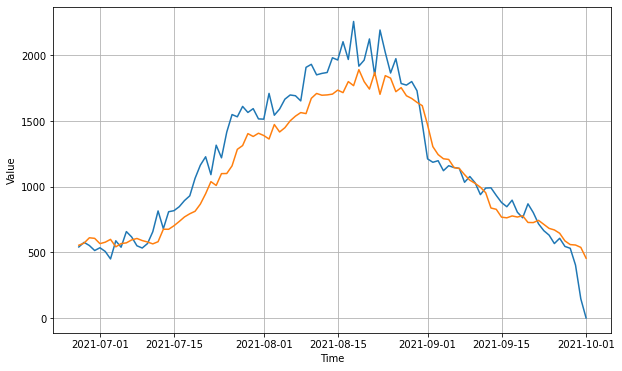

In [ ]:
#plt.figure(figsize=(10, 6))
#plot_series(time_valid, scaler.inverse_transform(x_valid))
#plot_series(time_valid, np.absolute(lin_forecast))
plt.figure(figsize=(10, 6))
plot_series(time_valid, scaler.inverse_transform(x_valid))
plot_series(time_valid, rnn_forecast)

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(x_valid, rnn_forecast)

1102.4735698603597

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(rnn_forecast, x_valid, squared=False)

1191.0736532436254

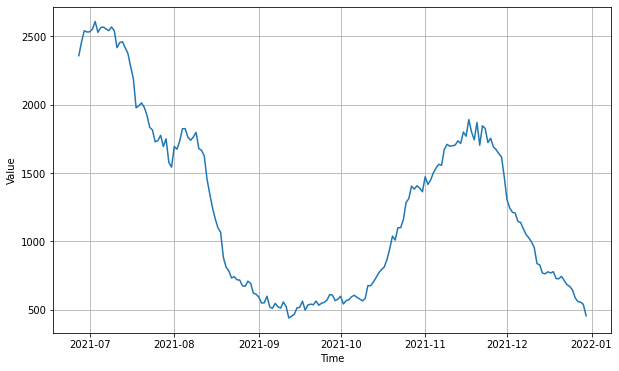

In [ ]:
plt.figure(figsize=(10, 6))
#plot_series(time_valid, scaler.inverse_transform(x_valid))
plot_series(time_valid1, rnn_forecastFuture)

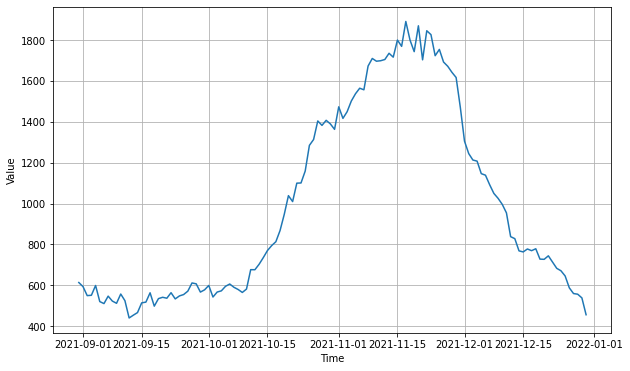

In [ ]:
plt.figure(figsize=(10, 6))
#plot_series(time_valid, scaler.inverse_transform(x_valid))
plot_series(time_valid_pred, rnn_forecastFuture1)

## Create LSTM model

In [ ]:
window_size = 5
#train_set = seq2seq_window_dataset(x_train, window_size, batch_size=8)
#valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=8)
train_set = TimeseriesGenerator(x_train, x_train, length = window_size, batch_size=1)
valid_set = TimeseriesGenerator(x_valid, x_valid, length = window_size, batch_size=1)

model = keras.models.Sequential(
    [
  keras.layers.LSTM(150, return_sequences=True, batch_input_shape=[1, None, 1 ]),
  keras.layers.LSTM(64, return_sequences=True, stateful=True),
  keras.layers.Dense(32),
  keras.layers.Dense(1),
  ]
)
model.compile(optimizer='adam', loss='mean_squared_error')
#reset_states = ResetStatesCallback()
early_stopping = keras.callbacks.EarlyStopping(patience=30)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpointLSTM.h5", save_best_only=True)





"\n\nmodel = Sequential([\n  keras.layers.LSTM(150, activation='relu', return_sequences=True, input_shape=(window_size, 1)),\n  keras.layers.LSTM(64, activation='relu'),\n  keras.layers.Dense(64),\n  keras.layers.Dense(1)\n  ]\n)\nmodel.compile(optimizer='adam', loss='mean_squared_error')\n"

In [ ]:
history = model.fit_generator(train_set, 
                              validation_data=valid_set, 
                              epochs=200,
                              callbacks=[early_stopping,model_checkpoint])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/200
465/465 [==============================] - 10s 12ms/step - loss: 0.0146 - val_loss: 0.0083
Epoch 2/200
465/465 [==============================] - 5s 10ms/step - loss: 0.0035 - val_loss: 0.0087
Epoch 3/200
465/465 [==============================] - 5s 10ms/step - loss: 0.0031 - val_loss: 0.0069
Epoch 4/200
465/465 [==============================] - 5s 10ms/step - loss: 0.0028 - val_loss: 0.0092
Epoch 5/200
465/465 [==============================] - 5s 10ms/step - loss: 0.0028 - val_loss: 0.0072
Epoch 6/200
465/465 [==============================] - 5s 10ms/step - loss: 0.0033 - val_loss: 0.0068
Epoch 7/200
465/465 [==============================] - 5s 10ms/step - loss: 0.0028 - val_loss: 0.0069
Epoch 8/200
465/465 [==============================] - 5s 10ms/step - loss: 0.0028 - val_loss: 0.0073
Epoch 9/200
465/465 [==============================] - 5s 10ms/step - loss: 0.0030 - val_loss: 0.0067
Epoch 10/200
465/465 [==============================] - 5s 10ms/step - loss: 0.00

In [ ]:
model = keras.models.load_model("my_checkpointLSTM.h5")

In [ ]:
days = 60

Make predictions with LSTM

In [ ]:
lstm_forecast = model.predict(series[np.newaxis, :, np.newaxis])
lstm_forecast = lstm_forecast[0, split_time - 1:- 1, 0]

In [ ]:
lstm_forecast1 = model.predict(series[np.newaxis, :, np.newaxis])
lstm_forecast1 = lstm_forecast1[0, split_time - (1+days):- 1, 0]

In [ ]:
lstm_forecastFuture1 = model.predict(series[np.newaxis, :, np.newaxis])
lstm_forecastFuture1 = lstm_forecastFuture1[0, split_time_pred - (1+days):-1, 0]

In [ ]:
time_valid2 = pd.DataFrame(time_valid, columns = ['Fecha'])
time_valid2

,Fecha
0,2021-06-27
1,2021-06-28
2,2021-06-29
3,2021-06-30
4,2021-07-01
...,...
92,2021-09-27
93,2021-09-28
94,2021-09-29
95,2021-09-30


In [ ]:
last_date1 = time_valid2["Fecha"].iloc[-1]

#date_1 = datetime.datetime.strptime(start_date, "%m/%d/%y")   split_time - days
#end_date = date_1 + datetime.timedelta(days=10)
for i in range(days):
  last_date1 = last_date1 + datetime.timedelta(days=1)
  time_valid2 = time_valid2.append({'Fecha': last_date1}, ignore_index=True)
time_valid2 = time_valid2.to_numpy().reshape(-1)

In [ ]:
time_valid_pred1 = time[split_time_pred:]

In [ ]:
time_valid_pred1 = pd.DataFrame(time_valid_pred1, columns = ['Fecha'])
time_valid_pred1

,Fecha
0,2021-08-31
1,2021-09-01
2,2021-09-02
3,2021-09-03
4,2021-09-04
5,2021-09-05
6,2021-09-06
7,2021-09-07
8,2021-09-08
9,2021-09-09


In [ ]:
last_date_pred1 = time_valid_pred1["Fecha"].iloc[-1]

#date_1 = datetime.datetime.strptime(start_date, "%m/%d/%y")   split_time - days
#end_date = date_1 + datetime.timedelta(days=10)
for i in range(days):
  last_date_pred1 = last_date_pred1 + datetime.timedelta(days=1)
  time_valid_pred1 = time_valid_pred1.append({'Fecha': last_date_pred1}, ignore_index=True)
time_valid_pred1 = time_valid_pred1.to_numpy().reshape(-1)

## Plot results LSTM

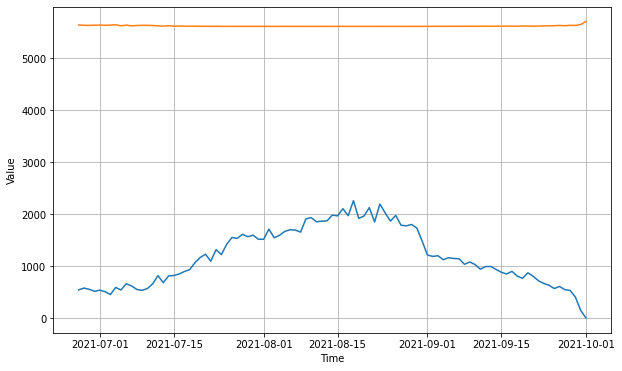

In [ ]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, scaler.inverse_transform(x_valid))
plot_series(time_valid, scaler.inverse_transform(lstm_forecast.reshape(-1,1)))

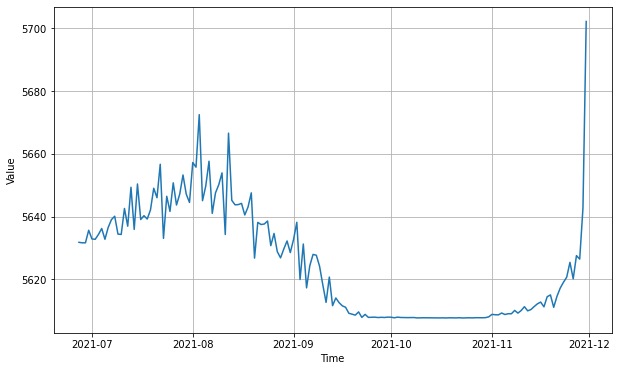

In [ ]:
plt.figure(figsize=(10, 6))

#plot_series(time_valid, scaler.inverse_transform(x_valid))
plot_series(time_valid2, scaler.inverse_transform(lstm_forecast1.reshape(-1,1)))

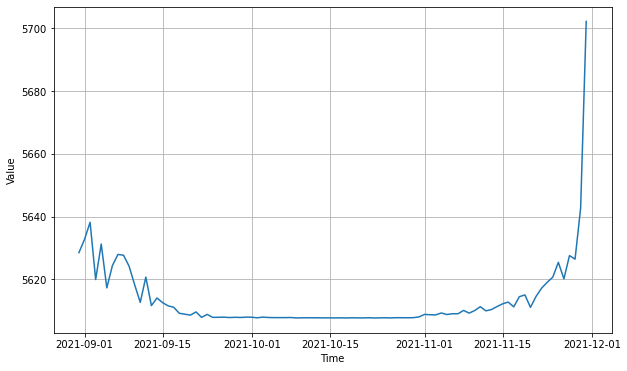

In [ ]:
plt.figure(figsize=(10, 6))
#plot_series(time_valid, scaler.inverse_transform(x_valid))
plot_series(time_valid_pred1, scaler.inverse_transform(lstm_forecastFuture1.reshape(-1,1)))